## Scatter Diagram: dBZ – geo-heights in different Storm Modes in WRF CONUS-1 Simulations. 

**Analysis:**
* **wrf-python derived 3D reflectivity**
* **geopotentail heights from CONUS-1 runs**
* **Derived Storm Mode Classification (5 classes)**

**For [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/).**

**Hungjui Yu 20211109**

In [140]:
# import sys
import time
import datetime as dt
# import pytz
from netCDF4 import Dataset # MFDataset
import numpy as np
import xarray as xr
import wrf

import matplotlib as mpl
import matplotlib.pyplot as plt

**Function: Set input files paths and names:**

In [141]:
def set_input_names(file_date):

    file_path_1_conus = '/gpfs/fs1/collections/rda/data/ds612.0'
    file_path_1_dbz = '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0'
    file_path_2 = '/' + wrf_sim_type # '/CTRL3D'
    file_path_3 = '/{}'.format(file_date.strftime('%Y'))

    file_names = dict( dbz = file_path_1_dbz
                           + file_path_2 
                           # + '/20110427' 
                           + '/20130913' 
                           # + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(file_date.strftime('%Y%m%d'))
                       , Z = file_path_1_conus
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_Z_{}.nc'.format(file_date.strftime('%Y%m%d'))
                     )
    
    return file_names

**Open data directly:**

In [142]:
## Set wrf simulation type:
wrf_sim_type = 'CTRL3D'
# wrf_sim_type = 'PGW3D'

## Set date time:
# case_date_time = dt.datetime(2011,4,27) 
case_date_time = dt.datetime(2013,9,13) 

file_name_list = set_input_names(case_date_time)
print(file_name_list)

{'dbz': '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/CTRL3D/20130913/wrf3d_d01_CTRL_dbz_20130913.nc', 'Z': '/gpfs/fs1/collections/rda/data/ds612.0/CTRL3D/2013/wrf3d_d01_CTRL_Z_20130913.nc'}


In [143]:
## Set hour:
## 0:00, 1:03, 2:06, 3:09, 4:12, 5:15, 6:18, 7:21
time_hour_idx = 0

## Get dBZ and CS mask data :
ds_wrf_dbz = xr.open_dataset(file_name_list['dbz'])

da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=time_hour_idx)
da_wrf_CSmask = ds_wrf_dbz['CS_mask'].isel(Time=time_hour_idx)
da_wrf_StormMode_mod =ds_wrf_dbz['Storm_Mode_mod'].isel(Time=time_hour_idx)
da_wrf_StormMode_str =ds_wrf_dbz['Storm_Mode_str'].isel(Time=time_hour_idx)

## Calculate the max. composite dBZ:
da_wrf_reflc = da_wrf_dbz.max(dim='bottom_top')

## Get geopotential height:
data_wrf_z_unstag = wrf.destagger(wrf.getvar(Dataset(file_name_list['Z']), 'Z', timeidx=time_hour_idx, meta=False), 0)


**Set parameters:**

In [144]:
mode_names = ['others', 'DCC', 'OCC', 'WCC', 'DWCC', 'BSR']
mode_type = 5

threshold_type = 'moderate'


**Set analysis variables:**

In [145]:
## Adjust the masks to fit 3d reflectivity grids:
exapnded_mode_m = da_wrf_StormMode_mod.expand_dims({'bottom_top':50}).data
exapnded_mode_s = da_wrf_StormMode_str.expand_dims({'bottom_top':50}).data
# exapnded_mode_m.data.shape
# exapnded_mode_m[3,:,:].plot()

analysis_var_dbz = da_wrf_dbz.where(exapnded_mode_m==mode_type)
analysis_var_geoh = np.where( (exapnded_mode_m==mode_type), data_wrf_z_unstag, np.nan )


In [146]:
# plt.scatter(plotting_var_1, plotting_var_2)
# plt.show()

### Test plot:

**Function: creating new scatter plot:**

In [147]:
def new_scatter(fig):
    
    ax = plt.axes()
    
    ax.set_xlim([0, 76])
    ax.set_xticks(np.arange(0,76,5))
    ax.set_xticklabels( np.arange(0,76,5) 
                      , fontsize=12
                      , fontweight='bold'
                      # , color=axis_color
                      # , rotation = 45
                      # , ha='right' # horizontalalignment
                      )
    
    ax.set_ylim([0, 20001])
    ax.set_yticks(np.arange(0, 20001, 2000))
    ax.set_yticklabels( np.arange(0, 20001, 2000)/1000
                      , fontsize=12
                      , fontweight='bold'
                      )
    
    # ax.spines['bottom'].set_color(axis_color)
    # ax.spines['bottom'].set_linewidth(2.5)
    
    return ax

**Do the plot:**

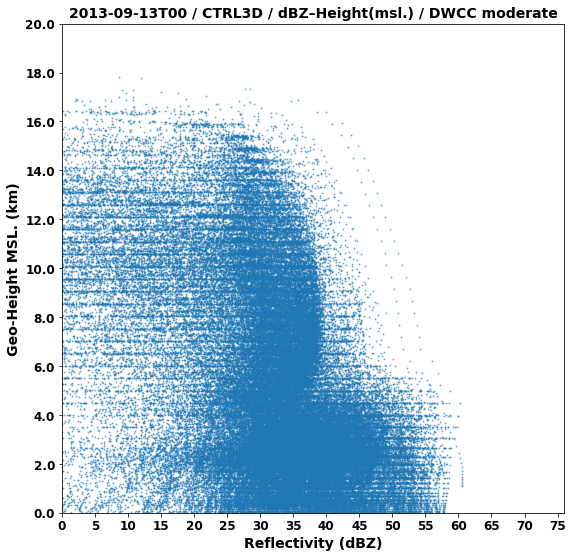

In [148]:
fig = plt.figure(figsize=(9,9))
ax1 = new_scatter(fig)

plotting_var_1 = analysis_var_dbz
plotting_var_2 = analysis_var_geoh

cf1 = ax1.scatter( plotting_var_1, plotting_var_2
                 , s=1
                 , alpha=0.5
                 )

## Labels:
plt.xlabel('Reflectivity (dBZ)', {'size': 14, 'weight': 'bold'})
plt.ylabel('Geo-Height MSL. (km)', {'size': 14, 'weight': 'bold'})

## Title:
cf1_title = plt.title( np.datetime_as_string(da_wrf_dbz.Time.data, unit='h')
                     + ' / ' + wrf_sim_type
                     + ' / dBZ–Height(msl.)'
                     + ' / ' + mode_names[mode_type] + ' ' + threshold_type
                     ,fontsize=14 
                     ,fontweight='bold'
                     # ,loc='left'
                     )

## Save figure:
fig_file_name = './' + np.datetime_as_string(da_wrf_dbz.Time.data, unit='h') + '_dBZ-geoH_' + mode_names[mode_type] + '_' + threshold_type[0:3] + '.png'
plt.savefig(fig_file_name, bbox_inches='tight', dpi=300)


In [149]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


<font color='teal'>**Supplement Codes:**</font>